# ECS7026P Neural Networks and Deep Learning - 2022/23 : Coursework 1


    Name: Mohammed Ataaur Rahaman
    Student Number: 220843052
    email: m.a.rahaman@se22.qmul.ac.uk
    Assignment Number: Coursework 1
    Module Code: ECS6P9U/P/7026P
    Module Name: Neural Networks and Deep Learning 

Imports 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

from torch import nn
from tqdm.auto import tqdm

In [2]:
!nvidia-smi

Mon Mar 20 20:12:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          On   | 00000000:E3:00.0 Off |                    0 |
|  0%   53C    P0    62W / 300W |      0MiB /  5067MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data Gathering

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# transform = transforms.Compose([transforms.ToTensor()])

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

In [5]:
# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

In [6]:
testset, trainset

(Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ),
 Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ))

## Data Preprocessing

In [7]:
BATCH_SIZE = 8
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

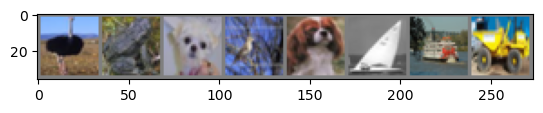

bird  frog  dog   bird  dog   ship  ship  truck


In [8]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{CLASSES[labels[j]]:5s}' for j in range(BATCH_SIZE)))


## Model

In [9]:
# class LeNet(torch.nn.Module):
#     def __init__(self, num_inputs, num_outputs):
#         super(LeNet, self).__init__()
#         self.num_inputs = num_inputs
#         self.num_outputs = num_outputs
#         C1 = 6
#         C2 = 16
#         L1 = 400
#         L2 = 120
#         L3 = 84
#         self.Convl1 = nn.Conv2d(num_inputs, C1, kernel_size = 5, padding = 2)
#         self.Sigmoid = nn.Sigmoid()
#         self.Avg1 = nn.AvgPool2d(2, stride=2, padding=0)
#         self.Convl2 = nn.Conv2d(C1,C2,kernel_size = 5)
#         self.Avg2 = nn.AvgPool2d(2, stride=2, padding=0)
#         self.Fltn = nn.Flatten()
#         self.Linear1 = nn.Linear(L1, L2)
#         self.Linear2 = nn.Linear(L2, L3)
#         self.Linear3 = nn.Linear(L3, num_outputs)
#     def forward(self, x):
#         out = self.Convl1(x)
#         out = self.Sigmoid(out)
#         out = self.Avg1(out)
#         out = self.Convl2(out)
#         out = self.Sigmoid(out)
#         out = self.Avg2(out)
#         #out = self.Sigmoid(out)
#         out = self.Fltn(out)
#         out = self.Linear1(out)
#         out = self.Sigmoid(out)
#         out = self.Linear2(out)
#         out = self.Sigmoid(out)
#         out = self.Linear3(out)
#         # out = self.Sigmoid(out)
#         return out

In [10]:
K = 5
N = 2
IMG_DIM = 32
IMG_CHANNELS = 3
HIDDEN_CHANNELS = 16
HIDDEN_CONV_KERNEL = 5
STRIDE = 1

# sap = nn.AvgPool2d(kernel_size=IMG_DIM)
# linear = nn.Linear(in_features=IMG_CHANNELS, out_features=K, bias=True)

# sigmoid = nn.Sigmoid()

In [11]:
# conv2d = nn.Conv2d(in_channels=IMG_CHANNELS, out_channels=HIDDEN_CHANNELS, kernel_size=HIDDEN_CONV_KERNEL)
# conv2d

In [12]:
class Backbone(nn.Module):

  def __init__(self, img_size=IMG_DIM, in_channels=IMG_CHANNELS, out_channels=HIDDEN_CHANNELS, kernel_size=HIDDEN_CONV_KERNEL, k=K, debug=False):
    super(Backbone, self).__init__()

    # Boolean to print debug logs.
    self.debug = debug

    self.spaitial_average_pool = nn.AvgPool2d(kernel_size=img_size)
    self.linear = nn.Sequential(
        nn.Linear(in_features=in_channels, out_features=k, bias=True),   # Question, can this be MLP?
        nn.Sigmoid(),      # Non Linear Activation
        # nn.ReLU(),
    )
    # self.non_linear = nn.Sigmoid()       # Non Linear Activation
    # self.non_linear = nn.ReLU()

    self.conv2ds = nn.ModuleList([
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size)
        for _ in range(k)
    ])

  def forward(self, x):
    sap_out = self.spaitial_average_pool(x).reshape(x.shape[0], -1)
    if self.debug: print(f"{sap_out.shape=}")

    g_out = self.linear(sap_out)
    #if self.debug: print(f"{lin_out.shape=}")

    #g_out = self.non_linear(lin_out)
    if self.debug: print(f"{g_out.shape=}")
    if self.debug: print(f"{g_out=}")

    outs = list()
    for a, conv2d in zip(g_out.transpose(0, 1), self.conv2ds):
      c_out = conv2d(x)
      if self.debug: print(f"{c_out.shape=}")
      if self.debug: print(f"{a.shape=}, \n{a=}")

      out = a.reshape(x.shape[0], 1, 1, 1)*c_out
      if self.debug: print(f"{out.shape=}")
      outs.append(out)
      
    out = sum(outs)
    if self.debug: print(f"{out.shape=}")

    return out

  def set_device_to(self, device='cuda'):
    if 'cuda' == device and not torch.cuda.is_available():
      print(f"Cuda not available")
      return

    self.spaitial_average_pool.to(device)
    self.linear.to(device)
    self.non_linear.to(device)

    for conv2d in self.conv2ds:
      conv2d.to(device)

In [13]:
# n = 5
# channels = [IMG_CHANNELS] + [HIDDEN_CHANNELS]*(n-1)

# [IMG_DIM + (STRIDE-HIDDEN_CONV_KERNEL)*i for i in range(n)]

In [14]:
# channels

In [15]:
class Model(nn.Module):

  def __init__(self, channels, Ks, kernel_size=HIDDEN_CONV_KERNEL, k=K, n=N, debug=False):
    super(Model, self).__init__()

    # Boolean to print debug logs.
    self.debug = debug
    self.Ks = Ks
    self.channels = channels
    self.img_sizes = [IMG_DIM + (STRIDE-kernel_size)*i for i in range(n+1)]

    if self.debug: print(f"{self.channels=}")
    if self.debug: print(f"{self.img_sizes=}")
    # if self.debug: print(f"{k=}")
    if self.debug: print(f"{self.Ks=}")
    if self.debug: print(f"{n=}")

    self.backbones = nn.ModuleList([
        Backbone(
            img_size=self.img_sizes[i], 
            in_channels=self.channels[i], 
            out_channels=self.channels[i+1], 
            kernel_size=kernel_size, 
            k=self.Ks[i], 
            debug=debug
        ) 
        for i in range(n)
    ])

    self.spaitial_average_pool = nn.AvgPool2d(kernel_size=self.img_sizes[-1])
    self.linear = nn.Linear(in_features=self.channels[-1], out_features=len(CLASSES), bias=False)

  def set_debug(self, debug=True):
    self.debug = debug
    for backbone in self.backbones:
      backbone.debug = debug

  def forward(self, x):
    for backbone in self.backbones:
      x = backbone(x)
    
    f = self.spaitial_average_pool(x).reshape(x.shape[0], -1)
    if self.debug: print(f"M: {f.shape=}")

    out = self.linear(f)
    if self.debug: print(f"M: {out.shape=}")

    return out

In [23]:
class Trainer:

  def __init__(self, model, criterion, optimizer, epochs, trainloader, testloader, logs_per_epoch=4) -> None:
    self.model = model
    self.criterion = criterion
    self.optimizer = optimizer
    
    self.epochs = epochs
    self.log_step = len(trainloader) // logs_per_epoch

    self.trainloader = trainloader
    self.testloader = testloader

    self.losses = list()
    self.val_losses = list()
    self.batch_losses = list()

  def train(self, use_gpu=False):

    for epoch in range(self.epochs):  # loop over the dataset multiple times

        batch_losses = list()
        running_loss = 0.0
        for i, data in tqdm(enumerate(self.trainloader, 0), total=len(trainloader)):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            if use_gpu:
              inputs = inputs.to('cuda')
              labels = labels.to('cuda')
            
            # zero the parameter gradients
            self.optimizer.zero_grad()

            # forward + backward + optimize
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            # print statistics
            batch_losses.append(loss.item())
            running_loss += loss.item()
            if i % self.log_step == self.log_step-1:    # print every 2000 mini-batches
                avg_loss = running_loss / self.log_step
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {avg_loss:.3f}')
                running_loss = 0.0
                self.batch_losses.append(avg_loss)

        self.losses.append(sum(batch_losses) / len(batch_losses))

        print(f"Train Loss : {self.losses[-1]}")
        self.eval()

    print('Finished Training')

  def eval(self):
    correct = 0
    total = 0
    losses = list()
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in self.testloader:
            images, labels = data
            if USE_GPU:
              images = images.to('cuda')
              labels = labels.to('cuda')

            # calculate outputs by running images through the network
            outputs = self.model(images)

            loss = self.criterion(outputs, labels)
            losses.append(loss.item())

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            
    val_loss = sum(losses) / len(losses)
    self.val_losses.append(val_loss)

    print(f"Val Loss : {val_loss}")
    
    accuracy = correct / total
    print(f'Accuracy of the network on the 10000 test images: {100 * accuracy:.2f} %')
    
  def plot(self):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 3)

    X = np.linspace(0, len(self.losses)-1, len(self.batch_losses))
    ax1.plot(X, self.batch_losses, label="Train Batches", color='C0', marker='x', linestyle='dashed', lw=1, alpha=0.7)
    ax1.plot(self.losses, label='Train', color='C0', marker='o', lw=3, alpha=1)
    ax1.plot(self.val_losses, label='Test', color='C1', marker='o', lw=3, alpha=1)
    ax1.legend()
    ax1.set(title=f'Loss Curve', xlabel='Epoch', ylabel='Loss')

    ax2.set(title=f'Accuracy Curve', xlabel='Epoch', ylabel='Accuracy')
    plt.tight_layout()
    fig.show()
    

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d: # by checking the type we can init different layers in different ways
        torch.nn.init.xavier_uniform_(m.weight)   

In [64]:
# Init model

IMG_DIM = 32
IMG_CHANNELS = 3
USE_GPU = True


# K = 5
# HIDDEN_CHANNELS = 16
HIDDEN_CONV_KERNEL = 5
STRIDE = 1

channels = [IMG_CHANNELS, 16, 32, 64, 128] #20, 25, 30]
Ks = channels
Ks = [5, 5, 5, 5, 5, 5, 5, 5]
N = len(channels) - 1

model = Model(
    Ks=Ks,
    channels=channels,
    kernel_size=HIDDEN_CONV_KERNEL, 
    k=K, 
    n=N, 
    debug=True
)

model.apply(init_weights)

if USE_GPU: model.to('cuda')


model

self.channels=[3, 16, 32, 64, 128]
self.img_sizes=[32, 28, 24, 20, 16]
self.Ks=[5, 5, 5, 5, 5, 5, 5, 5]
n=4


Model(
  (backbones): ModuleList(
    (0): Backbone(
      (spaitial_average_pool): AvgPool2d(kernel_size=32, stride=32, padding=0)
      (linear): Sequential(
        (0): Linear(in_features=3, out_features=5, bias=True)
        (1): Sigmoid()
      )
      (conv2ds): ModuleList(
        (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
        (1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
        (2): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
        (3): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
        (4): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
      )
    )
    (1): Backbone(
      (spaitial_average_pool): AvgPool2d(kernel_size=28, stride=28, padding=0)
      (linear): Sequential(
        (0): Linear(in_features=16, out_features=5, bias=True)
        (1): Sigmoid()
      )
      (conv2ds): ModuleList(
        (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
        (1): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
        (2): Conv2d

In [65]:
# Init optimizer 

LR = 0.0001 #1e-2
MOMENTUM = 0.9 #0.9


criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

model.set_debug(False)

In [66]:
# Init Trainer

EPOCHS = 3
BATCH_SIZE = 256

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


trainer = Trainer(
    model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    epochs=EPOCHS, 
    logs_per_epoch=4,
    trainloader=trainloader,
    testloader=testloader,
)

  0%|          | 0/196 [00:00<?, ?it/s]

[1,    49] loss: 2.045
[1,    98] loss: 1.970
[1,   147] loss: 1.924
[1,   196] loss: 1.898
Train Loss : 1.9591705884252275
Val Loss : 1.8811811238527298
Accuracy of the network on the 10000 test images: 33.60 %


  0%|          | 0/196 [00:00<?, ?it/s]

[2,    49] loss: 1.879
[2,    98] loss: 1.846
[2,   147] loss: 1.841
[2,   196] loss: 1.849
Train Loss : 1.8536214354086895
Val Loss : 1.8063641786575317
Accuracy of the network on the 10000 test images: 35.71 %


  0%|          | 0/196 [00:00<?, ?it/s]

[3,    49] loss: 1.828
[3,    98] loss: 1.812
[3,   147] loss: 1.796
[3,   196] loss: 1.791
Train Loss : 1.8065883620661132
Val Loss : 1.7781722784042358
Accuracy of the network on the 10000 test images: 35.91 %
Finished Training


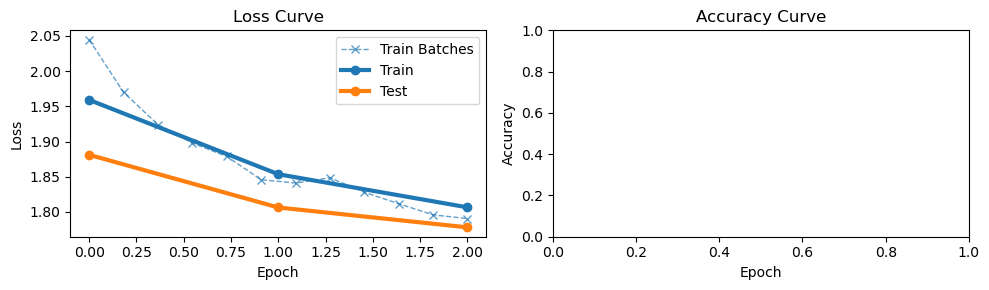

In [67]:
trainer.epochs = 3

trainer.train(use_gpu=USE_GPU)
trainer.plot()

  0%|          | 0/196 [00:00<?, ?it/s]

[1,    49] loss: 2.047
[1,    98] loss: 1.946
[1,   147] loss: 1.911
[1,   196] loss: 1.874
Train Loss : 1.9447236304380455
Val Loss : 1.8417323648929596
Accuracy of the network on the 10000 test images: 33.89 %


  0%|          | 0/196 [00:00<?, ?it/s]

[2,    49] loss: 1.837
[2,    98] loss: 1.818
[2,   147] loss: 1.807
[2,   196] loss: 1.790
Train Loss : 1.8128535121071094
Val Loss : 1.7583528071641923
Accuracy of the network on the 10000 test images: 37.64 %


  0%|          | 0/196 [00:00<?, ?it/s]

[3,    49] loss: 1.770
[3,    98] loss: 1.756
[3,   147] loss: 1.737
[3,   196] loss: 1.724
Train Loss : 1.746617821406345
Val Loss : 1.723293635249138
Accuracy of the network on the 10000 test images: 38.91 %
Finished Training


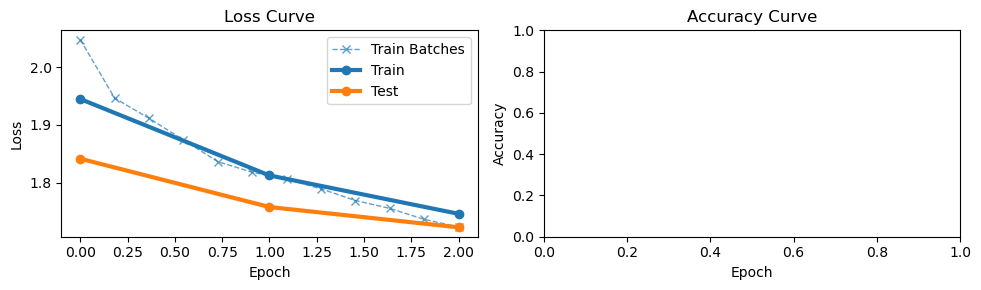

In [ ]:
trainer.epochs = 3

trainer.train(use_gpu=USE_GPU)
trainer.plot()